In [1]:
using DrWatson
@quickactivate :SwARExperiments

┌ Info: Precompiling SwARExperiments [370ede80-34d9-4915-b06a-c76e3bd073fe]
└ @ Base loading.jl:1317


In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

In [3]:
using Plots
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [4]:
function ar_ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ar_ssm (generic function with 1 method)

In [5]:
using WAV
signal, fs = WAV.wavread("../data/btb.wav")
signal = signal[1:2:end]

31679-element Vector{Float64}:
 -0.0019226660969878231
  0.0005493331705679495
  0.00445570238349559
  0.002075258644367809
  0.002685628833887753
  0.0008545182653279214
 -0.01370281075472274
 -0.0027466658528397473
  0.000640888698995941
  0.0004882961516159551
  0.003021332438123722
  0.0037537766655476546
  0.007263405255287332
  ⋮
 -0.01239051484725486
 -0.004974517044587542
 -0.0031128879665517136
 -0.004028443250831629
 -0.005340739158299509
 -0.012024292733542894
 -0.015045625171666617
 -0.015015106662190619
 -0.004058961760307627
  0.008728293710135197
 -0.003936887722403638
 -0.0025940733054597613

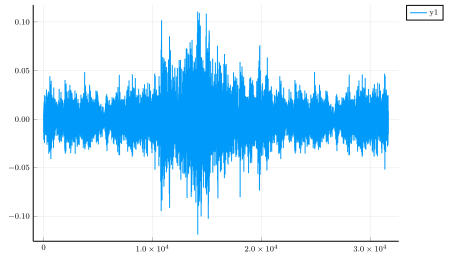

In [26]:
plot(signal)

In [13]:
inputs_bar, outputs_bar = ar_ssm(signal[1:10000], 2)
inputs_train, outputs_train = ar_ssm(signal[11000:20000], 2)

([[-0.008148442030091251, -0.0024414807580797754], [-0.007049775688955351, -0.008148442030091251], [-0.0004272591326639607, -0.007049775688955351], [0.00347911008026368, -0.0004272591326639607], [0.02948088015381329, 0.00347911008026368], [0.027619251075777458, 0.02948088015381329], [0.05746635334330271, 0.027619251075777458], [0.031159398174993132, 0.05746635334330271], [0.014496292001098667, 0.031159398174993132], [0.009552293465987122, 0.014496292001098667]  …  [0.023865474410229806, 0.015564439832758568], [0.029602954191717278, 0.023865474410229806], [0.02529984435560167, 0.029602954191717278], [0.02380443739127781, 0.02529984435560167], [0.022766808069093907, 0.02380443739127781], [0.020264290292062136, 0.022766808069093907], [0.027314065981017488, 0.020264290292062136], [0.008636738181707206, 0.027314065981017488], [-0.021912289803765986, 0.008636738181707206], [-0.008423108615375225, -0.021912289803765986]], [-0.007049775688955351, -0.0004272591326639607, 0.00347911008026368, 0.

In [14]:
# priors for train and bar sounds were extracted by means of bayesian AR
# see https://github.com/biaslab/AIDA/blob/master/src/environment/ar.jl
coefs_set = [[0.813870337218894, -0.1462282474234252], [1.0215122761169466, -0.29159434505180454]]
prec_set  = [2344.109805572215, 3827.9836114819877]
l_slice   = 5000
n_buckets = div(length(signal), l_slice)
n_states  = 2

2

## Switching AR

In [15]:
priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=5.494850780579807e9, b=2.344109805572215e6), GammaShapeRate{Float64}(a=1.4653458529774681e10, b=3.827983611481988e6)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.813870337218894, -0.1462282474234252]
Λ: [10000.0 0.0; 0.0 10000.0]
)
, MvNormalMeanPrecision(
μ: [1.0215122761169466, -0.29159434505180454]
Λ: [10000.0 0.0; 0.0 10000.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

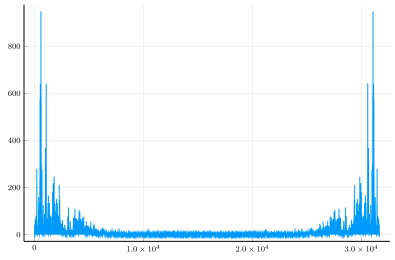

In [16]:
using FFTW
plot(abs.(fft(signal)).^2, label=false)

In [17]:

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)

SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=5.494850780579807e9, b=2.344109805572215e6), GammaShapeRate{Float64}(a=1.4653458529774681e10, b=3.827983611481988e6)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.813870337218894, -0.1462282474234252]
Λ: [10000.0 0.0; 0.0 10000.0]
)
, MvNormalMeanPrecision(
μ: [1.0215122761169466, -0.29159434505180454]
Λ: [10000.0 0.0; 0.0 10000.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

In [18]:
inputs, outputs = ar_ssm(signal, 2)
result = InferenceResults(inference_swar(inputs, outputs, n_buckets, 20, parameters)...);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


In [19]:
mean(result.mA[end])

2×2 Matrix{Float64}:
 0.639567  0.550675
 0.360433  0.449325

In [20]:
mean.(result.mθs[end])

6-element Vector{Vector{Float64}}:
 [0.7634071549061399, -0.14807489621716466]
 [0.8995515430472711, -0.1832895671699702]
 [1.1221083345652272, -0.37576781451966673]
 [0.8031076343912366, -0.12165252809464137]
 [0.7637493439921171, -0.14836729518066988]
 [0.8992107907673611, -0.18280587525137765]

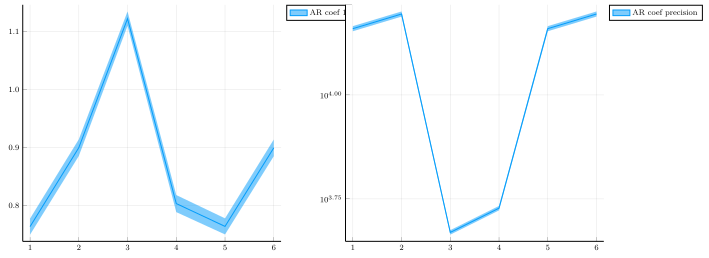

In [21]:
mθs = result.mθs
mγs = result.mγs

dimension(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
# plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
# plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

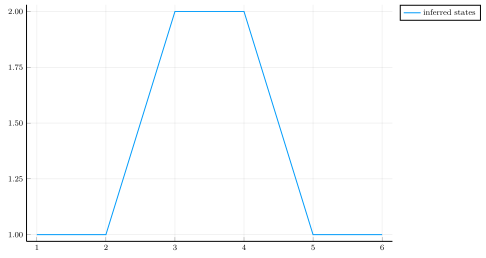

In [22]:
mzs = result.mzs
plot(mean.(mzs[end][1:end]), label="inferred states")


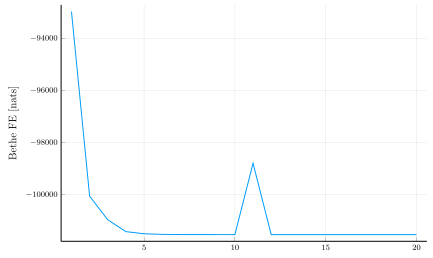

In [24]:
mfe = result.mfe
plot(mfe[1:end], label=:none, ylabel="Bethe FE [nats]")

In [ ]:
xs = collect(1:n_states)
ys = collect(1:n_states)
p1 = heatmap(xs, ys, mean(mA[end]), aspect_ratio = 1,color=:grays)
p2 = heatmap(xs, ys, gen_A, aspect_ratio = 1, color=:grays)
plot(p1, p2)

In [439]:
collect(1:n_states)

3-element Vector{Int64}:
 1
 2
 3

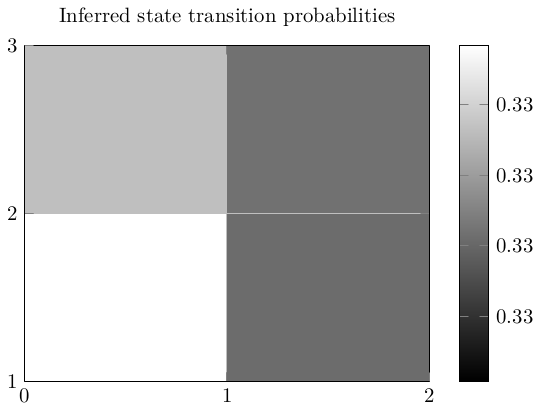

In [466]:
axis1 = @pgf Axis(
    {
        xtick=collect(0:n_states),
        ytick=collect(0:n_states),
        title="Inferred state transition probabilities",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/blackwhite",
        colorbar_style={"xticklabel pos=upper"}
    },
    Plot3(
        {
            surf,
            shader = "flat corner",
        },
        Coordinates(collect(1:3), collect(1:3), mean(mA[end]))),
    )